# Internal Links: Crawl an Entire Website

Internal links are one of the strongest ranking factors

Managing a logical heirarchy of links is important

Use this script to collect all the internal links or a domain



### About Alton

Follow me for more data and tutorials

- twitter: https://twitter.com/alton_lex @alton_lex

- linkedin: https://www.linkedin.com/in/altonalexander/


### About Data Winners

Join the conversation:

- private Discord community

- Video tutorials

- Feedback and support on this and other scripts

https://datawinners.gumroad.com/l/data-analytics-for-seo

In [31]:

domain = "https://bikelanes.com"
main_sitemap = domain + "/sitemap/sitemap-0.xml"

# store cached soup so we don't keep hitting the production site
soups = {}

In [32]:
# pages from sitemap

import requests
import pandas as pd
from lxml import etree

xmlDict = []

r = requests.get(main_sitemap)
root = etree.fromstring(r.content)
print ("The number of sitemap tags are {0}".format(len(root)))
for sitemap in root:
    children = sitemap.getchildren()
    xmlDict.append({'url': children[0].text})

df_sitemap = pd.DataFrame(xmlDict)
df_sitemap

The number of sitemap tags are 30021


,url
0,https://bikelanes.com/page/1
1,https://bikelanes.com/page/2
2,https://bikelanes.com/page/3
3,https://bikelanes.com/page/4
4,https://bikelanes.com/page/5
...,...
30016,https://bikelanes.com/disclosure/
30017,https://bikelanes.com/
30018,https://bikelanes.com/inspiration/
30019,https://bikelanes.com/privacy/


# Crawl the whole site looking for links

For more information see https://medium.com/swlh/how-to-build-a-url-crawler-to-map-a-website-using-python-3e7db83feb7a

In [33]:
from bs4 import BeautifulSoup
import requests
import requests.exceptions
from urllib.parse import urlsplit
from urllib.parse import urlparse
from collections import deque

In [34]:
# a queue of urls to be crawled next
new_urls = deque( list(df_sitemap['url']) )

# a set of urls that we have already processed 
processed_urls = set()

In [35]:
# a set of domains inside the target website
local_urls = set()
# a set of domains outside the target website
foreign_urls = set()
# a set of broken urls
broken_urls = set()

In [36]:

# store importance
local_url_importance = {}

# store source & target links
# The list format will look like for each pair [[“/what-is-physics”,”/what-is-motion”]]
links = {}

# store pages with links missing www
page_with_links_missing_www = set()

def add_and_process_local_link( source, local_link ):
    
    # skip self reference
    if "#" in local_link:
        return
    
    # if it is a self reference then ignore it
    if source == local_link.split("#")[0]:
        return
    # add to set of local urls
    local_urls.add(local_link)
    
    # add to source target list
    #links.append( [source, local_link] )
    if source in links:
        links[source].add(local_link)
    else:
        # create and add first time
        links[source] = set()
        links[source].add(local_link)
        
    
    # increment importance
    local_url_importance[local_link] = 1 + local_url_importance.get(local_link, 0)
    
    
def is_nav_link( link ):
    
    grandparent = link.parent.parent

    check_for = ['header', 'footer']

    is_nav_link = False
    for check in check_for:
        if check in str(grandparent):
            is_nav_link = True
            
    return is_nav_link

def remove_trail_slash(s):
    if s.endswith('/'):
        s = s[:-1]
    return s

In [ ]:
# process urls one by one until we exhaust the queue
nth = 0
while len(new_urls):
    # move next url from the queue to the set of processed urls
    url = new_urls.popleft()
    
    # clean
    url = remove_trail_slash( url.strip() )
    
    # check if already processed
    if url in processed_urls:
        continue
    
    # only crawl on page
    if domain not in url:
        continue
    
    # otherwise continue processing
    processed_urls.add(url)
    
    # get url's content
    nth = nth+1
    print(str(nth), "Processing %s" % url)
    
    # extract base url to resolve relative links
    parts = urlsplit(url)
    base = "{0.netloc}".format(parts)
    strip_base = base.replace("www.", "")
    base_url = "{0.scheme}://{0.netloc}".format(parts)
    path = url[:url.rfind('/')+1] if '/' in parts.path else url

    if url in soups:
        # use cache
        soup = soups[url]
    else:
        try:
            response = requests.get(url)
        except (requests.exceptions.MissingSchema, requests.exceptions.ConnectionError, requests.exceptions.InvalidURL, requests.exceptions.InvalidSchema):
            # add broken urls to it's own set, then continue
            broken_urls.add(url)
            continue

        # create a beutiful soup for the html document
        soup = BeautifulSoup(response.text, "lxml")
        # cache it
        soups[url] = soup
    
    # only get links in the body
    for link in soup.find('body').find_all('a'):
        
        # if this is a nav link then skip it
        if is_nav_link( link ):
            continue
        
        # extract link url from the anchor
        anchor = link.attrs["href"] if "href" in link.attrs else ''

        # cleanup by removing parameters
        anchor = anchor.split("?")[0]
        
        # remove trailing slash
        anchor = remove_trail_slash(anchor)
        
        if 'http:' in anchor:
            anchor = anchor.replace("http:","https:")
            
        # skip these special cases
        if "mailto:" in anchor:
            continue
        if "tel:" in anchor:
            continue
        if "javascript:" in anchor:
            continue
        
        if anchor.startswith('/'):
            local_link = base_url + anchor
            #local_urls.add(local_link)
            add_and_process_local_link( url, local_link )
        elif strip_base in anchor:
            #local_urls.add(anchor)
            add_and_process_local_link( url, anchor )
        elif not anchor.startswith('http'):
            local_link = path + anchor
            #local_urls.add(local_link)
            add_and_process_local_link( url, local_link )
        else:
            foreign_urls.add(anchor)

        for i in local_urls:
            if not i in new_urls and not i in processed_urls:
                new_urls.append(i)
 

# page importance

In [38]:
# df of importance
pages_local_url_importance = []

for page in local_url_importance:
    pages_local_url_importance.append({'url':page, 'count':local_url_importance[page]})
df_page_importance = pd.DataFrame(pages_local_url_importance)
df_page_importance = df_page_importance.sort_values('count',ascending=False)
df_page_importance[0:10]

,url,count
958,https://bikelanes.com/,75
1,https://bikelanes.com/routes,57
2,https://bikelanes.com/safety,57
3,https://bikelanes.com/commute,57
4,https://bikelanes.com/gear,57
5,https://bikelanes.com/about,56
6,https://bikelanes.com/contact,56
7,https://bikelanes.com/privacy,56
0,https://bikelanes.com/page/,19
999,https://bikelanes.com/san-diego,7


# Page analysis

In [40]:
# page
len(links)

57

In [42]:
len(broken_urls)

0

# Graph analysis


References:

- https://www.briggsby.com/internal-link-analysis-with-python
- https://importsem.com/create-a-topical-internal-link-graph-with-networkx-and-python/

In [2]:
%pip install plotly
%pip install networkx

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.2.2 -> 23.0.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip available: 22.2.2 -> 23.0.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [49]:

import networkx as nx


In [46]:
source_target_list = []

for source in list(df_page_importance['url']):
    for target in links.get(source,[]):
        source_target_list.append(
            [
                source.replace(domain,""), 
                target.replace(domain,"")
            ])

In [47]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import networkx as nx
from numpy import random as nprand
import pandas as pd
import random
import re


seed = 5 # my lucky number
nprand.seed(seed)
random.seed(seed)

G = nx.DiGraph(source_target_list)

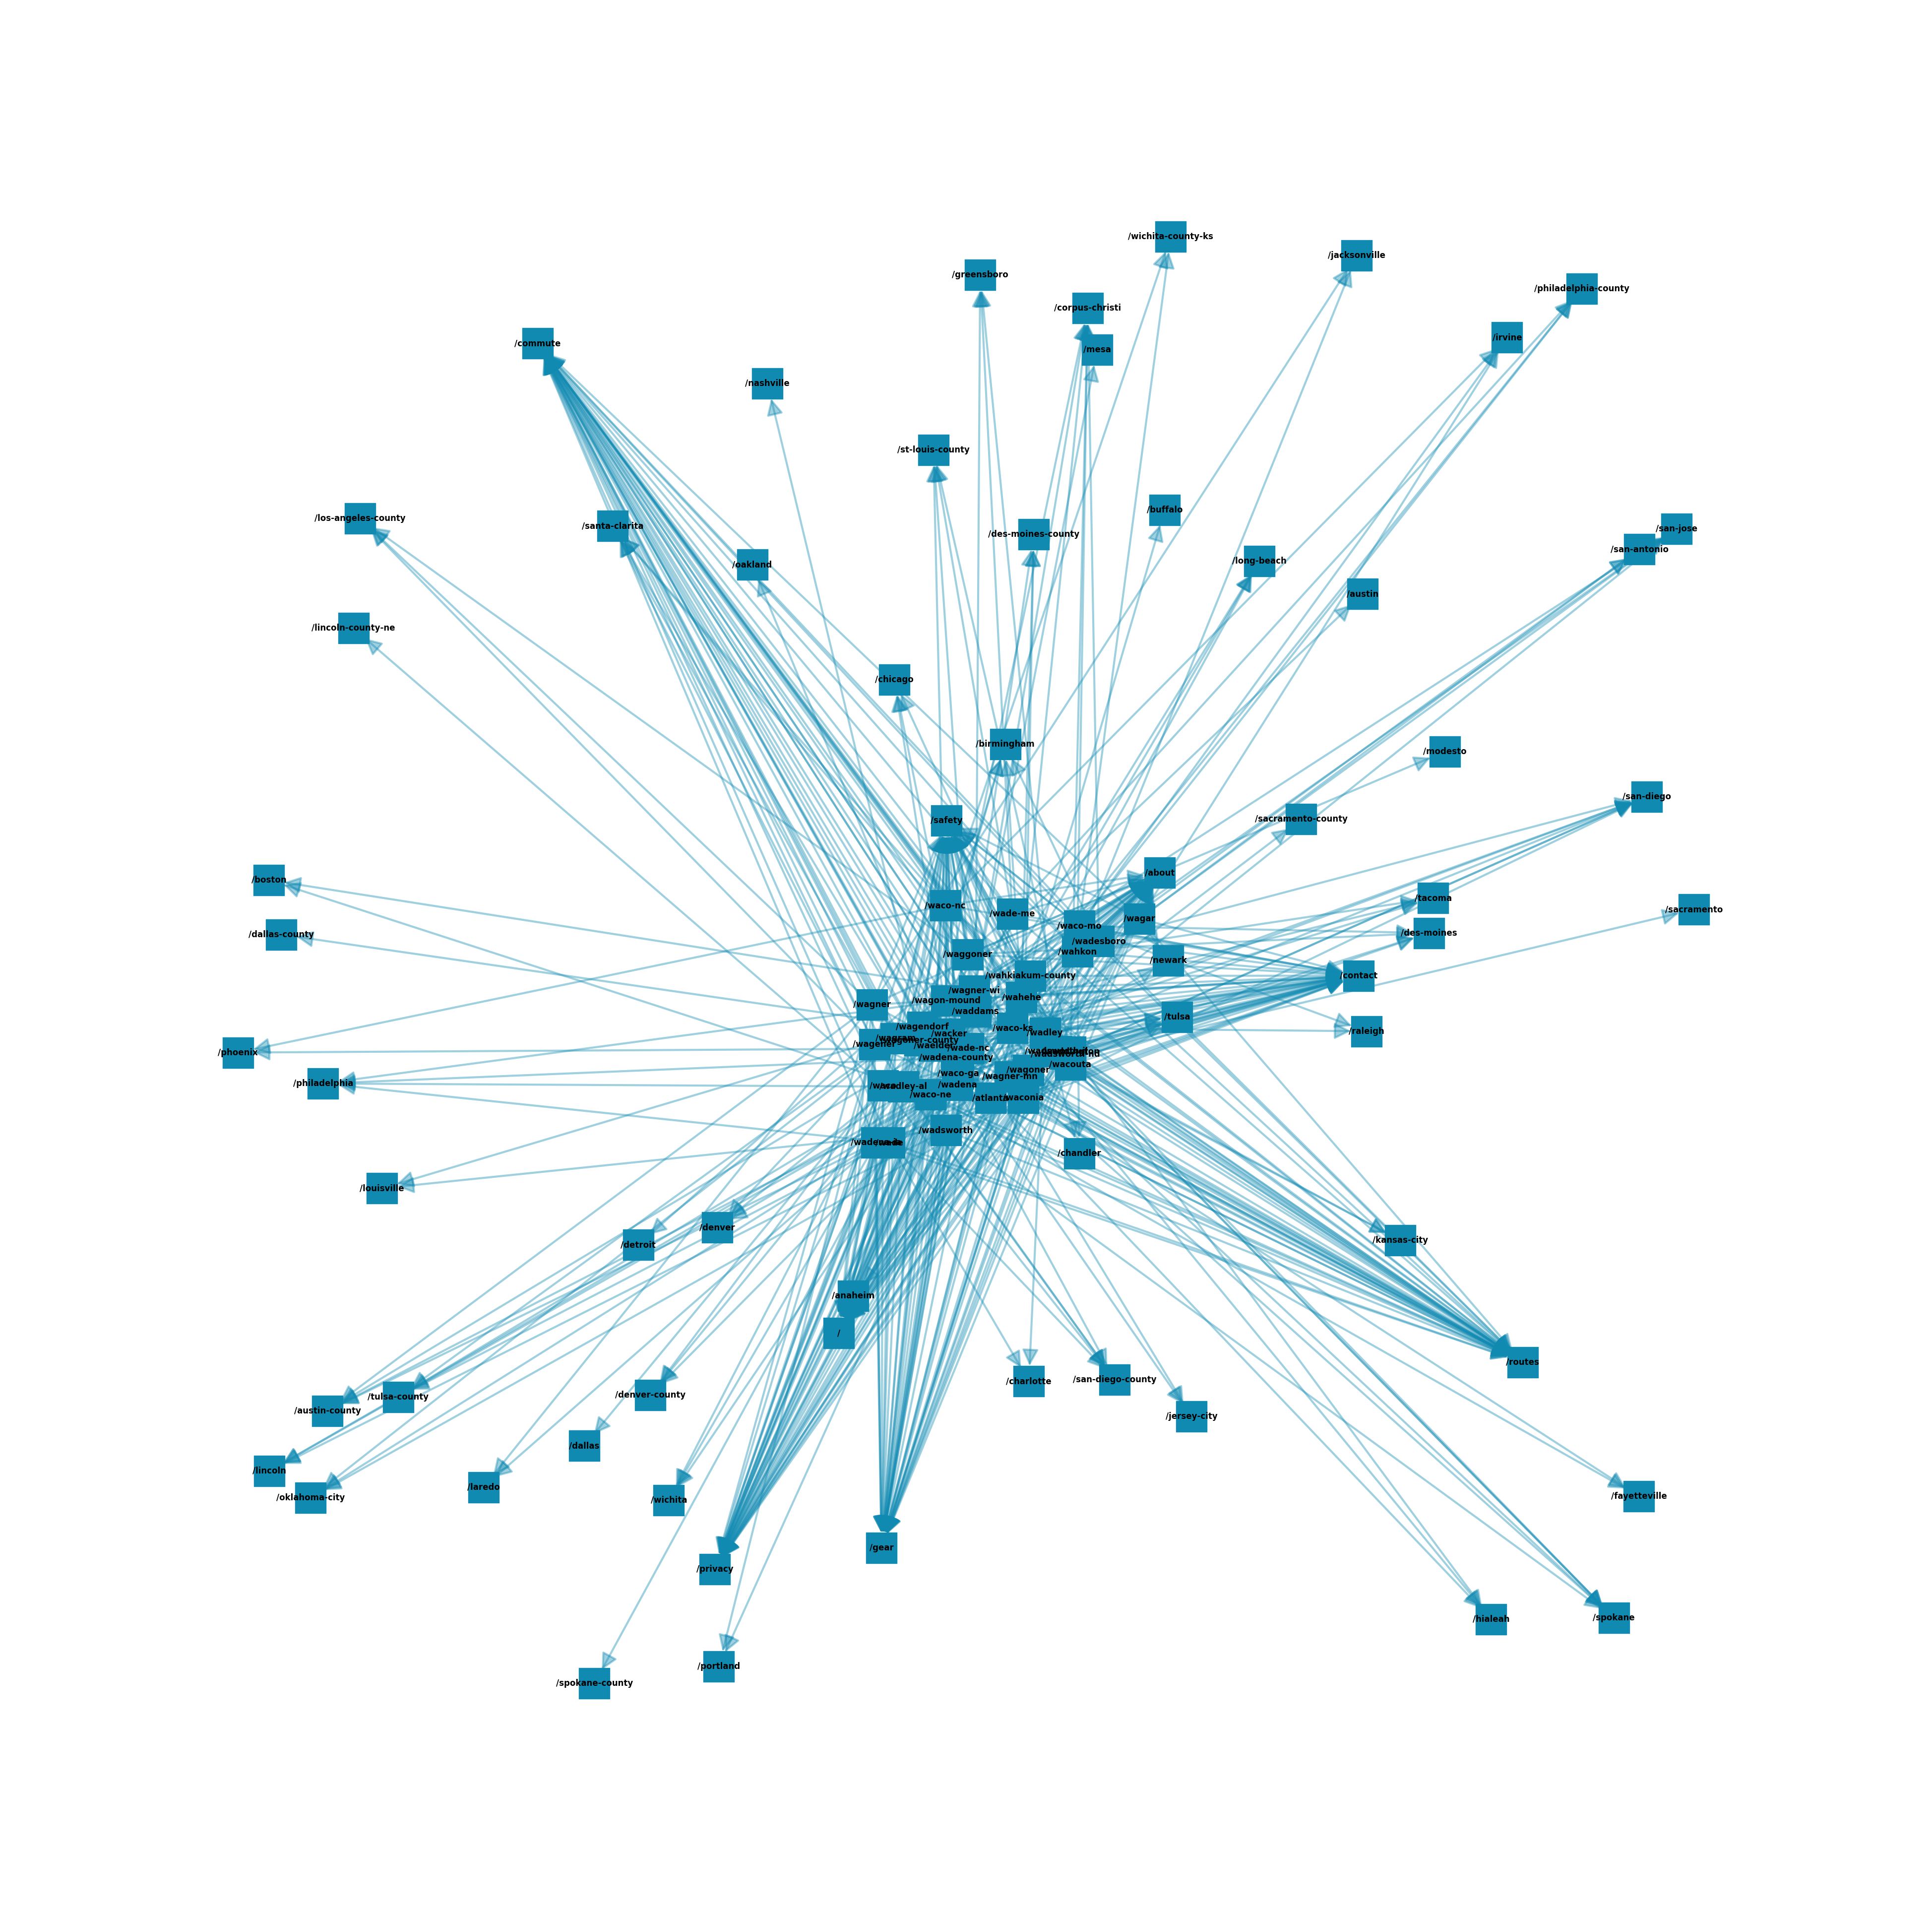

In [48]:
pos = nx.spring_layout(G, k=.001)

api_links = [x for x in source_target_list]

nx.draw_networkx_edges(G, pos, width=3, alpha=0.4,
                       edge_color="#118AB2", arrowsize=50, 
                       node_size=2000, edgelist=api_links)

pages = [v for v in G.nodes]

nx.draw_networkx_nodes(G, pos, nodelist=pages,
                       node_color="#118AB2", node_shape="s", 
                       node_size=2000)

nx.draw_networkx_labels(G, pos, font_size=12, font_weight="bold")

plt.gca().margins(0.1, 0.1)
plt.axis("off")
plt.rcParams['figure.figsize'] = [50, 50]
plt.rcParams['figure.facecolor'] = 'white'
plt.show()